# LLM Abliteration v1.3 script, adapted for 01-ai/Yi-1.5-9B-Chat

Author: byroneverson

This script ran at kaggle.com, accelerator: P100, persistence: Files only

# Download 01-ai/Yi-1.5-9B-Chat model locally

In [ ]:
%cd /kaggle/working

from huggingface_hub import snapshot_download
snapshot_download(repo_id="01-ai/Yi-1.5-9B-Chat", local_dir="./Yi-1.5-9B-Chat")


# Install requirements for the entire process

Assumes your environment already has all the usual libs installed (transformers, etc). This script was run with kaggle so only a few extras are needed.

In [ ]:
%cd /kaggle/working
!pip install jaxtyping
!pip install transformers
!pip install tqdm
!pip install einops
!pip install torch
!pip install bitsandbytes
!pip install accelerate

# Generate layer embedding outputs for all sample instructions and save locally

In [ ]:
%cd /kaggle/working

import random
import os
import gc
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer, BitsAndBytesConfig
from datasets import load_dataset
import jaxtyping
import einops
from tqdm import tqdm

# Clear memory of past model usage
model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache()

torch.inference_mode()

local_repo_dir = "/kaggle/working/Yi-1.5-9B-Chat"
working_dir = "/kaggle/working"

model = AutoModelForCausalLM.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True, 
                                             torch_dtype=torch.float16, 
                                             quantization_config=BitsAndBytesConfig(load_in_4bit=True,
                                                                                    bnb_4bit_compute_dtype=torch.float16))
tokenizer = AutoTokenizer.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True)
tokenizer.pad_toke_id = 0

# Settings
# I have used 128 and 256 with success but may as well use the max for a better estimation
instructions = 512
#layer_idx = int(len(model.model.layers) * 0.5) #6)

print("Instruction count: " + str(instructions))

dataset = load_dataset("byroneverson/abliterate-refusal", split="train")

# Filter the dataset based on 'target'
harmful_dataset = dataset.filter(lambda x: x['target'] == True)
harmless_dataset = dataset.filter(lambda x: x['target'] == False)

# Randomly select 512 entries from each filtered dataset
harmful_instructions = random.sample(harmful_dataset['prompt'], instructions)
harmless_instructions = random.sample(harmless_dataset['prompt'], instructions)

dataset = None
harmful_dataset = None
harmless_dataset = None
gc.collect()
torch.cuda.empty_cache()

# Progress
max_its = instructions * 2
bar = tqdm(total=max_its)

# Generate target layer hidden state files for harmful and harmless features
def save_target_hidden_states(prompt, index, feature):
    bar.update(n=1)
    toks = tokenizer.apply_chat_template(conversation=[{"role": "user", "content": prompt}], add_generation_prompt=True,
                                  return_tensors="pt")
    # Generates using each example, cache is disables so it doesn't keep previous examples in it's context, obviously we need to output the full states
    # It would be ideal if we could have it output the states for only the layer we want
    output = model.generate(toks.to(model.device), use_cache=False, max_new_tokens=1, return_dict_in_generate=True, output_hidden_states=True)
    # We still select the target layers, then only keep the hidden state of the last token (-1 part)
    hidden = torch.stack([layer[:, -1, :] for layer in output.hidden_states[0]], dim=0)
    # Squeeze away token dimension, remove token_embedding layer output? 
    hidden = hidden.squeeze(1)[1:, :]
    # Save each hidden state to disk to keep memory usage at a minimum
    dir_path = working_dir + "/" + feature + "_states"
    file_path = dir_path + "/" + str(index) + ".pt"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    torch.save(hidden, file_path)

# Save harmful states
for index, instruction in enumerate(harmful_instructions):
    save_target_hidden_states(instruction, index, "harmful")

# Save harmless states
for index, instruction in enumerate(harmless_instructions):
    save_target_hidden_states(instruction, index, "harmless")

# End progress bar
bar.close()

# Clean-up
model = None
harmful_instructions = None
harmless_instructions = None
gc.collect()
torch.cuda.empty_cache()


# Get refusal direction vector using my PCA (Primary Component Analysis) algorithm and save

My algorithm is so scatter-brained currently, this one is easy though because I just matched the layer_index to the 16K version that I had great results with and preliminary testing seems like that layer works just as well for this model too. Hopefully the benchmarks reflect this.

NOTE: For this model my current algorithm does not seem to be working too well and I believe it to be for the following reasons:
1. The main features causing refusal do not have much variation and therefore exist in the 5th PC instead of the 1st.
2. My algorithm is not yet developed enough to automatically choose the PC/layer with the strongest cosine similarity to the mean_diff.
3. If the wrong PC is chosen for analysis then there won't be a separation between the harmful and harmless regions.

See my glm-4-9b-chat abliteration for an example of a "walk in the park" usage of my algorithm. I simply setup the script the same as I did for gemma-2-27b0it and it was able to pin-point the best layer for refusal mitigation, this was due to the 1st PC being the one analyzed and also happened to be the PC with the most cosine similarity to the mean_diff. Soon the algorithm will scan the PCs for the best candidate and probably do much more like tailoring a unique refusal direction vector per layer instead of applying the "one size fits all" method currently in use.

We are able use the output graphs (specifically the cosine similarity) to visually see which layer would be the best candidate as far as I know.

For this model I have chose to go with the output of graph "cosine similarity: abs-sum of layer" to choose the layers that closely resembles the mean_diff based on PCA.

/kaggle/working
Using z-score threshold: 0.5244004726409912


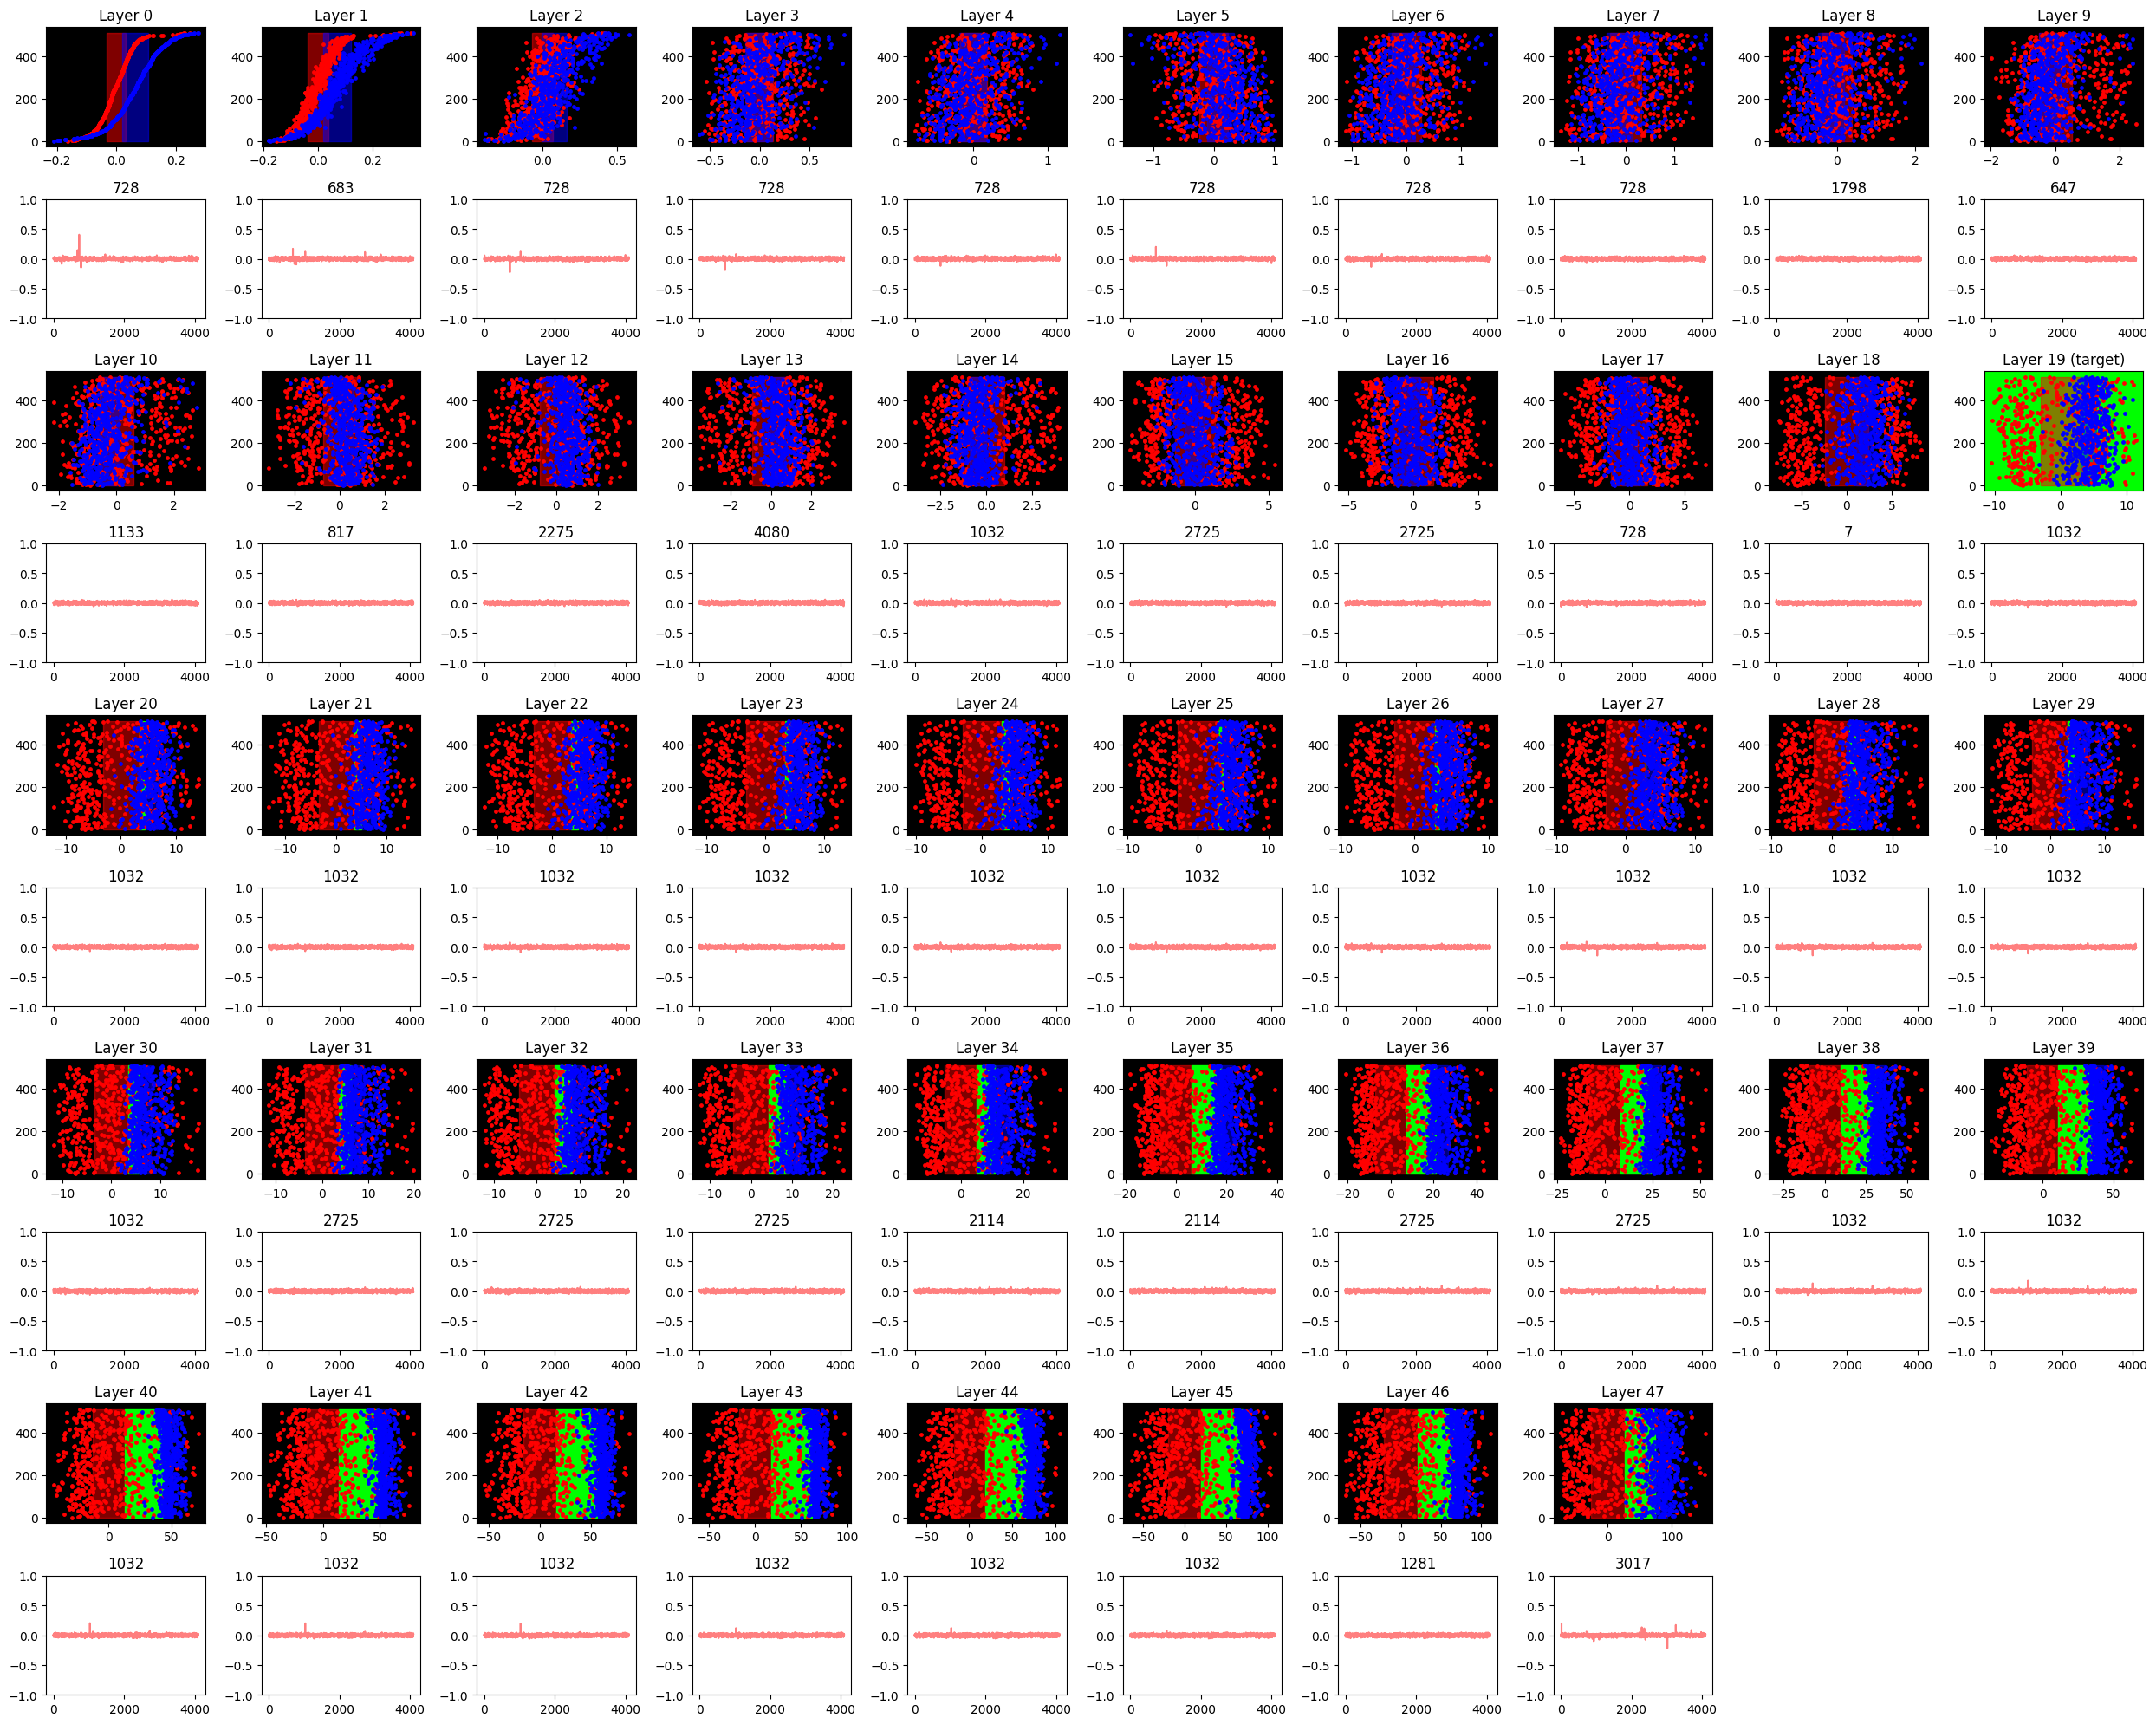

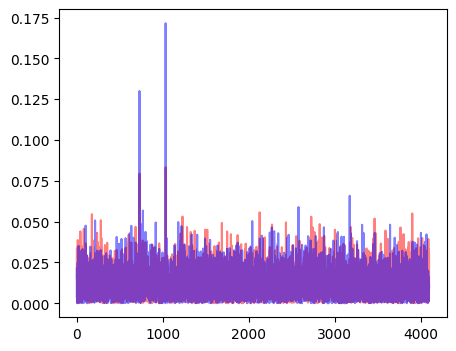

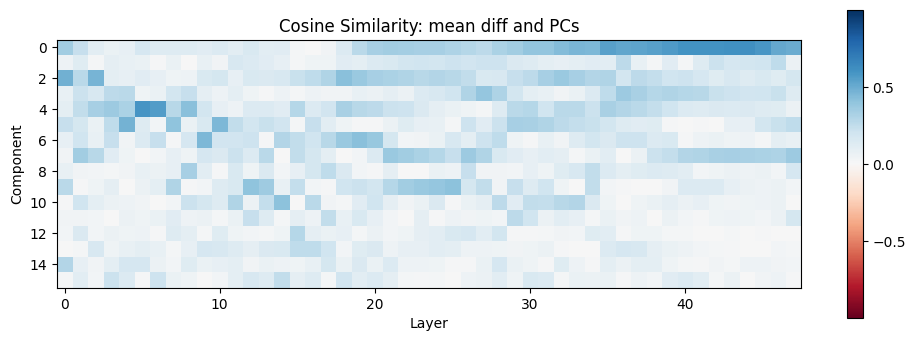

torch.Size([16, 48])
torch.Size([16, 48])
tensor(0)


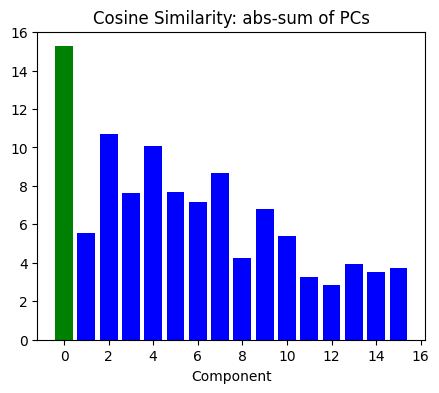

torch.Size([16, 48])
torch.Size([16, 48])
tensor(34)


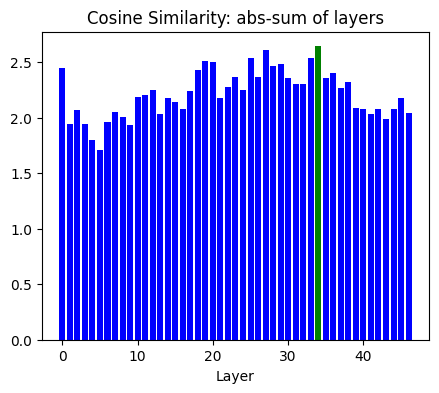

Using layer index: 21


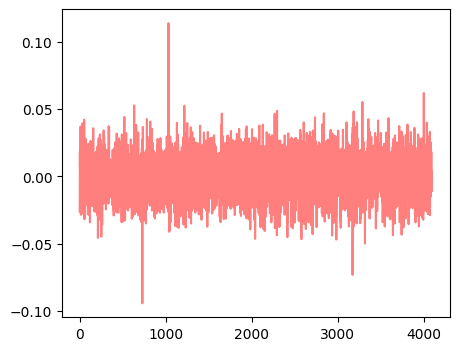

tensor([-0.0262,  0.0043,  0.0184,  ..., -0.0071, -0.0018, -0.0031],
       dtype=torch.float16)


16947

In [16]:
%cd /kaggle/working

import torch
import math
import os
import gc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

local_repo_dir = "/kaggle/working/Yi-1.5-9B-Chat"
working_dir = "/kaggle/working"
instructions = 512 #256 #32
n_components = 16 #10
n_layers = 48

gc.collect()
torch.cuda.empty_cache()

# Load tensors
harmful_tensors = [torch.load(f"{working_dir}/harmful_states/{i}.pt", weights_only=True) for i in range(instructions)]
harmless_tensors = [torch.load(f"{working_dir}/harmless_states/{i}.pt", weights_only=True) for i in range(instructions)]

# Create data
harmful_data = torch.stack(harmful_tensors).cpu()
harmless_data = torch.stack(harmless_tensors).cpu()

harmful_tensors = None
harmless_tensors = None
gc.collect()
torch.cuda.empty_cache()

pca_components = []
gaps = []

# We can create a majority region of our PCAs by removing the outliers via z-score thresholding
# Once the two regions (harmful and harmless PCA 1st component) are separated we know refusal has been introduced
# The amount of separation that we deem to be "enough" can be controlled by our coverage hyper-parameter
# Calculate our z-score threshold based on coverage
coverage = 0.4
# Inverse CDF on normal distribution with probability equal to our coverage, both tail ends will be trimmed so icdf is used accordingly
z_score_threshold = torch.distributions.normal.Normal(loc=0, scale=1).icdf(torch.tensor([coverage + (1 - coverage) / 2])).item()
print(f"Using z-score threshold: {z_score_threshold}")

# Plot
pca_index = 0 #1
plots_per_layer = 2
nrows = math.ceil(n_layers / 10)
ncols = 10
fig, ax = plt.subplots(nrows=nrows * 2, ncols=ncols, figsize=(5 * 10 // 2, 4 * nrows * 2 // 2))
harmful_sort = []
harmless_sort = []
pca = PCA(n_components=n_components)
for i in range(n_layers):
    # PCA
    #pca = PCA(n_components=n_components)
    harmful_pca = torch.tensor(pca.fit_transform(harmful_data[:, i, :]))
    harmless_pca = torch.tensor(pca.transform(harmless_data[:, i, :]))
    pca_components.append(torch.tensor(pca.components_))
    
    # Sort sample instructions for cleaner starting visual
    if i == 0:
        harmful_sort = torch.argsort(harmful_pca[:, 0], descending=False)
        harmless_sort = torch.argsort(harmless_pca[:, 0], descending=False)
    harmful_pca = harmful_pca[harmful_sort]
    harmless_pca = harmless_pca[harmless_sort]
    
    # Find max and min excluding outliers using Z-score
    # Coverage is a normalized percentage of included elements based on a normal distribution, 99.73% (0.9973) would be a z_score of 3
    def majority_bounds(tensor, pca_index, z_score_threshold=z_score_threshold):
        z_scores = (tensor - tensor.mean()) / tensor.std()
        filtered_indices = torch.where(torch.abs(z_scores) < z_score_threshold)[0]
        filtered = torch.index_select(tensor, 0, filtered_indices)
        return (filtered.min(), filtered.max())
    harmful_min, harmful_max = majority_bounds(harmful_pca[:, pca_index], 0)
    harmless_min, harmless_max = majority_bounds(harmless_pca[:, pca_index], 0)
    
    # Plot
    row = int(i / 10) * 2
    col = i % 10
    y_height = harmful_pca.shape[0]
    y_range = range(y_height)
    ax[row, col].add_patch(plt.Rectangle((harmful_min, 0), harmful_max - harmful_min, y_height, color='red', alpha=0.5))
    ax[row, col].add_patch(plt.Rectangle((harmless_min, 0), harmless_max - harmless_min, y_height, color='blue', alpha=0.5))
    if harmless_min > harmful_max:
        ax[row, col].add_patch(plt.Rectangle((harmful_max, 0), harmless_min - harmful_max, y_height, color=(0, 1, 0), alpha=1.0))
        gaps.append(harmless_min - harmful_max)
    elif harmful_min > harmless_max:
        ax[row, col].add_patch(plt.Rectangle((harmless_max, 0), harmful_min - harmless_max, y_height, color=(0, 1, 0), alpha=1.0))
        gaps.append(harmful_min - harmless_max)
    else:
        gaps.append(0)
    ax[row, col].scatter(harmful_pca[:, pca_index], y_range, color='red', s=6, label='Harmful')
    ax[row, col].scatter(harmless_pca[:, pca_index], y_range, color='blue', s=6, label='Harmless')
    
    # Components Plot
    comp_row = row + 1
    x_range = range(pca.components_.shape[1])
    delta_components = None
    if i == 0:
        delta_components = pca_components[i][pca_index]
    else:
        delta_components = pca_components[i][pca_index]
        #delta_components = pca_components[i][pca_index] - pca_components[i-1][pca_index]
    #components_2 = pca_components_2[i][pca_index]
    ax[comp_row, col].plot(x_range, delta_components, color="red", alpha=0.5)
    #ax[comp_row, col].plot(x_range, components_2, color="blue", alpha=0.5)
    ax[comp_row, col].set_title(f"{delta_components.abs().argmax()}")
    ax[comp_row, col].set_ylim([-1, 1])
    
# Remove un-used plot cells
for i in range(n_layers, nrows * 10):
    row = int(i / 10) * 2
    col = i % 10
    comp_row = row + 1
    ax[row, col].set_title("")
    ax[row, col].axis("off")
    ax[comp_row, col].set_title("")
    ax[comp_row, col].axis("off")
    
# Iterate through our layers until we detect separation between harmful and harmless
layer_index = -1
for i in range(n_layers):
    row = int(i / 10) * 2
    col = i % 10
    if gaps[i] > 0 and layer_index < 0:
        ax[row, col].set_facecolor((0, 1, 0))
        layer_index = i
        ax[row, col].set_title(f"Layer {i} (target)")
    else:
        ax[row, col].set_facecolor((0, 0, 0))
        ax[row, col].set_title(f"Layer {i}")
    
    
plt.tight_layout()
plt.show()

# Convert PCA components to PyTorch tensor
pca_components = torch.stack(pca_components, dim=1)

pca_components_mean = pca_components[pca_index][24].abs() #.abs()[24] #.mean(dim=0)
plt.figure(figsize=(5, 4))
plt.plot(range(pca_components_mean.shape[0]), pca_components_mean / pca_components_mean.norm(), color="red", alpha=0.5)
#plt.show()

# Instructions mean
#harmful_mean = harmful_data.mean(dim=0)
#harmless_mean = harmless_data.mean(dim=0)
# Test using a range of layers for mean_diff
mean_diff_start = 4 #int(n_layers * 0.25)
mean_diff_end = n_layers - 2 #int(n_layers - n_layers * 0.25)
harmful_mean = harmful_data[mean_diff_start : mean_diff_end].mean(dim=0)
harmless_mean = harmless_data[mean_diff_start : mean_diff_end].mean(dim=0)
mean_diff = harmless_mean - harmful_mean #- harmless_mean

mean_diff_mean = mean_diff[24].abs() #.mean(dim=0)
#plt.figure(figsize=(5, 4))
plt.plot(range(mean_diff_mean.shape[0]), mean_diff_mean / mean_diff_mean.norm(), color="blue", alpha=0.5)
plt.show()

# Calculate cosine similarity using PyTorch
cosine_similarities = torch.cosine_similarity(mean_diff.unsqueeze(0), pca_components, dim=-1)

# Visualize cosine similarities
plt.figure(figsize=(12, 4))
plt.imshow(cosine_similarities.abs(), cmap='RdBu', interpolation='nearest', vmin=-1.0, vmax=1.0)
cbar = plt.colorbar()
cbar.set_ticks([-0.5, 0.0, 0.5])
plt.xlabel('Layer')
plt.ylabel('Component')
plt.title('Cosine Similarity: mean diff and PCs')
plt.show()

# Get PC that correlates the most with mean_diff
print(cosine_similarities.shape)
sim_abs = cosine_similarities.abs()
sim_abs_sum = sim_abs.sum(dim=-1)
print(sim_abs.shape)
top_index = sim_abs_sum.argmax()
print(top_index)
colors = ["blue"] * sim_abs_sum.shape[0]
colors[top_index] = "green"
plt.figure(figsize=(5, 4))
plt.bar(x=range(sim_abs_sum.shape[0]), height=sim_abs_sum, color=colors)
plt.xlabel('Component')
plt.title('Cosine Similarity: abs-sum of PCs')
plt.show()

# Get layer that correlates the most with mean_diff
print(cosine_similarities.shape)
sim_abs = cosine_similarities.abs()
# Test ignoring the top PC for the analysis to check only subtle variations
# The idea being that the variations between harmful and harmless only becomes the greatest once the model has already started refusing
sim_abs_sum = sim_abs[:, 1:].sum(dim=0)
print(sim_abs.shape)
top_index = sim_abs_sum.argmax()
print(top_index)
colors = ["blue"] * sim_abs_sum.shape[0]
colors[top_index] = "green"
plt.figure(figsize=(5, 4))
plt.bar(x=range(sim_abs_sum.shape[0]), height=sim_abs_sum, color=colors)
plt.xlabel('Layer')
plt.title('Cosine Similarity: abs-sum of layers')
plt.show()
# TESTING: Set layer_index to top similarity of layer and mean_diff
#layer_index = top_index

# Find the orientation of of each layer for top_sim_pc
orientation = cosine_similarities / sim_abs

# DEBUG: Match the same layer as the 16K context version of the model that had great results
layer_index = 21



# Ideal layer index
if layer_index == -1:
    layer_index = n_layers // 2
print(f"Using layer index: {layer_index}")

# Save ideal layer mean_diff as refusal direction
mean_diff = -(mean_diff[layer_index])
refusal_direction = mean_diff / mean_diff.norm()

# Test targeting features
#manual_direction = torch.zeros(4096, dtype=torch.float16)
#manual_direction[3584] = 1.0
#refusal_direction = manual_direction

#count = 0
#for i in range(refusal_direction.shape[0]):
#    if refusal_direction[i].abs() < 0.000:
#        refusal_direction[i] = 0
#        count += 1
#print(f"Removed {count} of {refusal_direction.shape[0]} embed dims.")

plt.figure(figsize=(5, 4))
plt.plot(range(refusal_direction.shape[0]), refusal_direction, color="red", alpha=0.5)
plt.show()

print(refusal_direction)
if not os.path.exists(local_repo_dir):
    os.makedirs(local_repo_dir)
torch.save(refusal_direction, local_repo_dir + "/" + "refusal_direction.pt")

# Clean-up
cosine_similarities = None
pca_components = None
differences = None
variances = None
scores = None
harmful_data = None
harmless_data = None
harmful_mean = None
harmless_mean = None
mean_diff = None
gc.collect()

# Optional: Apply our method to quant model and test via chat
You can skip this step if you simply just want to patch the model without testing.

Modified weights will not be quantized (tok_embeddings, attention.wo, feed_forward.w2)

Credits:

https://www.lesswrong.com/posts/jGuXSZgv6qfdhMCuJ/refusal-in-llms-is-mediated-by-a-single-direction

https://github.com/FailSpy/abliterator

https://gemini.google.com/

In [ ]:
%cd /kaggle/working

from typing import Optional, Tuple
import gc
import einops
import jaxtyping
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, TextStreamer, BitsAndBytesConfig

model = None
gc.collect()
torch.cuda.empty_cache()

torch.inference_mode()

torch.set_default_device("cpu")

local_repo_dir = "/kaggle/working/Yi-1.5-9B-Chat"

model = AutoModelForCausalLM.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True, 
                                             device_map="cuda", 
                                             quantization_config=BitsAndBytesConfig(load_in_4bit=True, 
                                                                                    llm_int8_skip_modules=["o_proj", "down_proj"], 
                                                                                    bnb_4bit_compute_dtype=torch.bfloat16))
tokenizer = AutoTokenizer.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True)
config = AutoConfig.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True)
print(config)

# Match the dytpe of the model for the test, the final processing will perform the orthogonalization in float32 for higher accuracy
refusal_direction = torch.load(local_repo_dir + "/refusal_direction.pt", weights_only=True)

def orthogonalize_matrix(matrix: jaxtyping.Float[torch.Tensor, "... d"], 
                        direction: jaxtyping.Float[torch.Tensor, "d"]) -> jaxtyping.Float[torch.Tensor, "... d"]:
    proj = einops.einsum(matrix, direction.view(-1, 1), "... d, d single -> ... single") * direction
    return matrix - proj

# Orthogonalize tok_embeddings
device = model.model.embed_tokens.weight.device
refusal_direction_compute = refusal_direction.to(model.model.embed_tokens.weight.dtype).to(device)
emb_orthogonalized = orthogonalize_matrix(model.model.embed_tokens.weight, refusal_direction_compute)
model.model.embed_tokens.weight.data.copy_(emb_orthogonalized)

# Orthogonalize layers
start_idx = 0
end_idx = start_idx + 32
for idx in range(start_idx, end_idx):
    # wo must be rearranged for orthogonalization and reversed when complete
    device = model.model.layers[idx].self_attn.o_proj.weight.device
    refusal_direction_compute = refusal_direction.to(model.model.layers[idx].self_attn.o_proj.weight).to(device)
    wo_rearranged = einops.rearrange(model.model.layers[idx].self_attn.o_proj.weight, 
                                     "m (n h) -> n h m", n=config.num_attention_heads).to(device)
    wo_orthogonalized = orthogonalize_matrix(wo_rearranged, refusal_direction_compute)
    wo_rearranged = einops.rearrange(wo_orthogonalized, "n h m -> m (n h)", n=config.num_attention_heads).to(device)
    model.model.layers[idx].self_attn.o_proj.weight.data.copy_(wo_rearranged)
    wo_rearranged = None
    wo_orthogonalized = None
    
    # w2 must be transposed for orthogonalization and reversed when complete
    device = model.model.layers[idx].mlp.down_proj.weight.device
    refusal_direction_compute = refusal_direction.to(model.model.layers[idx].mlp.down_proj.weight).to(device)
    w2_transposed = model.model.layers[idx].mlp.down_proj.weight.T.to(device)
    w2_orthogonalized = orthogonalize_matrix(w2_transposed, refusal_direction_compute)
    w2_transposed = w2_orthogonalized.T.to(device)
    model.model.layers[idx].mlp.down_proj.weight.data.copy_(w2_transposed)
    w2_transposed = None
    w2_orthogonalized = None

# Clean-up before test chat
gc.collect()
torch.cuda.empty_cache()

conversation = []

streamer = TextStreamer(tokenizer)

print(f"Chat:")
while True:
    prompt = input()
    conversation.append({"role": "user", "content": prompt})
    toks = tokenizer.apply_chat_template(conversation=conversation,
        add_generation_prompt=True, return_tensors="pt")
    with torch.no_grad():
        gen = model.generate(toks.to(model.device), streamer=streamer, max_new_tokens=200)
        decoded = tokenizer.batch_decode(gen[0][len(toks[0]):], skip_special_tokens=True)
        conversation.append({"role": "assistant", "content": "".join(decoded)})
    break

# Optional: Remove temporary harmful and harmless hidden state files

In [ ]:
%cd /kaggle/working
!rm -r ./harmless_states
!rm -r ./harmful_states

# Modify individual safetensors files separately to save memory

In [ ]:
%cd /kaggle/working

from safetensors import safe_open
from safetensors.torch import save_file
import einops
import jaxtyping
import torch
import gc

model = None
gc.collect()
torch.cuda.empty_cache()

local_repo_dir = "/kaggle/working/Yi-1.5-9B-Chat"
safetensors_count = 4

config = AutoConfig.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True)
refusal_direction = torch.load(local_repo_dir + "/refusal_direction.pt", weights_only=True).to(torch.float32)

def orthogonalize_matrix(matrix: jaxtyping.Float[torch.Tensor, "... d"], 
                        direction: jaxtyping.Float[torch.Tensor, "d"]) -> jaxtyping.Float[torch.Tensor, "... d"]:
    proj = einops.einsum(matrix, direction.view(-1, 1), "... d, d single -> ... single") * direction
    return matrix - proj

def load_safetensors_file(file_path):
    tensors = {}
    with safe_open(file_path, framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)
    return tensors

# Make sure safetensors count matches the actual count for the model you are modifying
print("Processing .safetensors ...")
device = refusal_direction.device
for idx in range(safetensors_count):
    filename = "model-" + str(idx + 1).zfill(5) + "-of-" + str(safetensors_count).zfill(5) + ".safetensors"
    print(filename)
    file_path = local_repo_dir + "/" + filename
    tensors = load_safetensors_file(file_path)
    
    for tensor in tensors:
        # tok_embeddings
        if ".embed_tokens.weight" in tensor:
            print("• " + tensor)
            dtype = tensors[tensor].dtype
            t = tensors[tensor].to(torch.float32).to(device)
            tensors[tensor].copy_(orthogonalize_matrix(t, refusal_direction).to(dtype))
            t = []
        
        # attention.wo
        if ".self_attn.o_proj.weight" in tensor:
            print("• " + tensor)
            dtype = tensors[tensor].dtype
            t = tensors[tensor].to(torch.float32).to(device)
            t_rearranged = einops.rearrange(t, "m (n h) -> n h m", n=config.num_attention_heads).to(device)
            t_orthogonalized = orthogonalize_matrix(t_rearranged, refusal_direction)
            tensors[tensor].copy_(einops.rearrange(t_orthogonalized, "n h m -> m (n h)", n=config.num_attention_heads).to(dtype))
            t = []
            t_rearranged = []
            t_orthogonalized = []
        
        # feed_forward.w2
        if ".mlp.down_proj.weight" in tensor:
            print("• " + tensor)
            dtype = tensors[tensor].dtype
            t = tensors[tensor].to(torch.float32).to(device)
            t_transposed = t.T.to(device)
            t_orthogonalized = orthogonalize_matrix(t_transposed, refusal_direction)
            tensors[tensor].copy_(t_orthogonalized.T.to(dtype))
            t = []
            t_transposed = []
            t_orthogonalized = []
            
    # Save file
    save_file(tensors, file_path, metadata={'format': 'pt'})

# Patching done
print("Done.")


# Test chat with abliterated model

NOTE: I had to use a seriously unsavory prompt to test this model's limits and will not be posting the output here.

Long story short: It would only answer this specific question if I used layer 17, so this confirmed my manual setting.

In [ ]:
%cd /kaggle/working

import gc
import jaxtyping
import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, TextStreamer, BitsAndBytesConfig

model = []
gc.collect()
torch.cuda.empty_cache()

torch.inference_mode()

torch.set_default_device("cpu")

local_repo_dir = "/kaggle/working/Yi-1.5-9B-Chat"

model = AutoModelForCausalLM.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True, 
                                             device_map="cuda", 
                                             quantization_config=BitsAndBytesConfig(load_in_4bit=True, 
                                                                                    bnb_4bit_compute_dtype=torch.float16))
tokenizer = AutoTokenizer.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True)
config = AutoConfig.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True)
print(config)

gc.collect()
torch.cuda.empty_cache()

conversation = []

streamer = TextStreamer(tokenizer)

print(f"Chat:")
while True:
    prompt = input()
    conversation.append({"role": "user", "content": prompt})
    toks = tokenizer.apply_chat_template(conversation=conversation,
        add_generation_prompt=True, return_tensors="pt")
    with torch.no_grad():
        gen = model.generate(toks.to(model.device), streamer=streamer, max_new_tokens=200)
        decoded = tokenizer.batch_decode(gen[0][len(toks[0]):], skip_special_tokens=True)
        conversation.append({"role": "assistant", "content": "".join(decoded)})
    break

# Upload to huggingface

Be sure to change the repo_id to your repo

Also make sure you have secrets setup in kaggle for appropriate huggingface write token

If you aren't using kaggle secrets feature then you could always put the huggingface write token directly into the token param of upload_folder (insecure)

In [ ]:
%cd /kaggle/working/

# Delete parent readme so we don't overwrite in our repo
!rm /kaggle/working/Yi-1.5-9B-Chat/README.md
!rm /kaggle/working/Yi-1.5-9B-Chat/md5

import gc

model = []
gc.collect()
torch.cuda.empty_cache()

local_repo_dir = "Yi-1.5-9B-Chat"
repo_id = "byroneverson/Yi-1.5-9B-Chat-abliterated"

from kaggle_secrets import UserSecretsClient
token = UserSecretsClient().get_secret("hf_write") 

from huggingface_hub import upload_folder

upload_folder(folder_path=local_repo_dir, repo_id=repo_id, token=token)